In [1]:
%matplotlib inline
import eradiate.scenes as ertsc
from eradiate import unit_registry as ureg
import eradiate.scenes as ertsc
import numpy as np
from eradiate.srf_tools import spectral_filter
import matplotlib.pyplot as plt
from eradiate.scenes.atmosphere import MolecularAtmosphere

                      Filtering summary                       
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Characteristic         ┃  Initial  ┃  Final   ┃ Difference ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━┩
│ Lower wavelength       │ 380.0 nm  │ 759.0 nm │  379.0 nm  │
│ Upper wavelength       │ 2199.0 nm │ 765.0 nm │ -1434.0 nm │
│ # wavelength           │   1820    │    7     │   -1813    │
│ Wavelength range width │ 1819.0 nm │  6.0 nm  │ -1813.0 nm │
│ Wavelength bandwidth   │  6.9 nm   │  5.9 nm  │  -1.0 nm   │
│ Mean wavelength        │ 762.0 nm  │ 762.0 nm │  -0.0 nm   │
└────────────────────────┴───────────┴──────────┴────────────┘

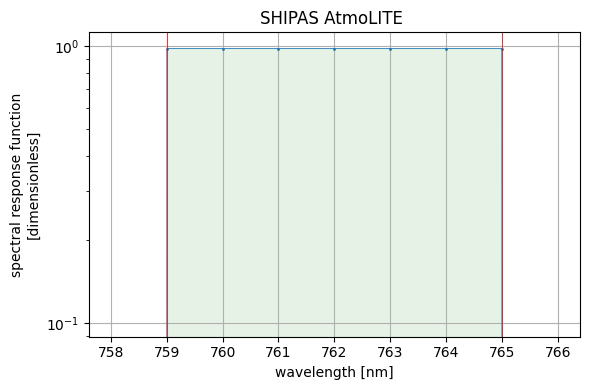

Writing filtered data to /home/cy0/gitclones/eradiate_simulations/SHIPAS_cut.nc

In [2]:
import eradiate
from eradiate.srf_tools import filter_srf

filtered_response_path = "/home/cy0/gitclones/eradiate_simulations/SHIPAS_cut.nc"
filtered = filter_srf(
    srf="/home/cy0/gitclones/eradiate_simulations/SHIPAS_filter.nc",
    path=filtered_response_path,
    wmin=759 * ureg.nm,
    wmax=765 * ureg.nm,
    verbose=True,
    show_plot=True,
    dry_run=False,
)

In [3]:
import eradiate
eradiate.set_mode("ckd")

IFOV = 4.0/71

FOV_AtmoLITE = 1.4
FOV_AtmoLITE_sim_pixel = 1.4*(1/IFOV)/2

measures={
    "type": "multi_distant",
    #"spectral_cfg":{"wavelengths": [763]},
    #"spectral_cfg": band_pass,
    "origin": [-7212, 0 , 90] * ureg.km,
    "target": [0, 0, 100] * ureg.km,
    "up": [0, 0, 1],
    "film_resolution": (71, 71),
    "spp": 10, #
    "fov": 4.0,
}

camera_oblique = ertsc.measure.PerspectiveCameraMeasure(
    id="camera_oblique",
    origin=measures['origin'],
    target=measures['target'],
    up=measures['up'],
    film_resolution=measures['film_resolution'],
    spp=measures['spp'],
)

illumination = ertsc.illumination.DirectionalIllumination(
    zenith=70.0, azimuth=0.0
)


#Substance	Albedo (% reflectance)
#Whole Planet	0.31
#Cumulonimbus Clouds	0.9
#Stratocumulus Clouds	0.6
#Cirrus Clouds	0.5

# https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2000GL012580
# "The average albedo of Earth is about 0.3"

surface_bsdf = ertsc.bsdfs.LambertianBSDF(reflectance=0.3)

atmosphere = MolecularAtmosphere.afgl_1986(has_absorption=True, has_scattering=True,binset="1nm",)
exp_ssa = eradiate.experiments.AtmosphereExperiment(
    geometry="spherical_shell",
)

#rayleigh_atmosphere = HeterogeneousAtmosphere(molecular_atmosphere=MolecularAtmosphere.afgl_1986(
#    has_absorption=True, has_scattering=True))


offset = [0, 0, exp_ssa.geometry.planet_radius.m_as(ureg.km)] * ureg.km

measures_spherical={
    "type": "perspective",
    "origin": measures['origin'] +offset,
    "target": measures['target'] +offset,
    "up": measures['up'],
    "film_resolution": measures['film_resolution'],
    "spp": measures['spp'],
    "fov": measures['fov'],
    "srf":filtered_response_path,
}

exp_ssa = eradiate.experiments.AtmosphereExperiment(
    geometry="spherical_shell",
    illumination = illumination,
    atmosphere=atmosphere,
    surface=surface_bsdf,
    measures=measures_spherical,
)



/usr/lib/python3/dist-packages/paramiko/transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


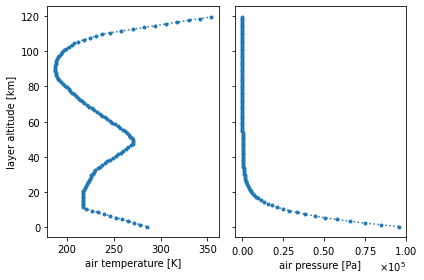

In [4]:
def show_profile(*atmospheres, labels=None):
    from matplotlib.ticker import ScalarFormatter

    if labels is None:
        label_iter = iter([None for _ in atmospheres])
    else:
        label_iter = iter(labels)

    fig, axs = plt.subplots(1, 2, sharey=True)

    for atmosphere in atmospheres:
        temperature = atmosphere.radprops_profile.thermoprops.t
        pressure = atmosphere.radprops_profile.thermoprops.p

        with plt.rc_context({"lines.linestyle": ":", "lines.marker": "."}):
            temperature.plot(y="z_layer", ax=axs[0])
            pressure.plot(y="z_layer", ax=axs[1], label=next(label_iter))

    formatter = ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((-3,2))
    axs[1].xaxis.set_major_formatter(formatter)
    axs[1].set_ylabel("")

    if labels is not None:
        fig.legend(
        bbox_to_anchor=(1.0, 0.5),
        loc="center left",
        borderaxespad=0.0,
    )
    plt.rcParams["figure.figsize"] = (15,15)
    plt.tight_layout()
    plt.show()
    plt.close()

show_profile(atmosphere)

In [5]:
# run_simulation
result = eradiate.run(exp_ssa)

0/112|          | 00:00, ETA=?

In [6]:
result

<xarray.Dataset>
Dimensions:     (sza: 1, saa: 1, w: 7, y_index: 71, x_index: 71, srf_w: 7)
Coordinates:
  * sza         (sza) float64 70.0
  * saa         (saa) float64 0.0
  * y_index     (y_index) int64 0 1 2 3 4 5 6 7 8 ... 62 63 64 65 66 67 68 69 70
    y           (y_index) float64 0.0 0.01429 0.02857 ... 0.9714 0.9857 1.0
  * x_index     (x_index) int64 0 1 2 3 4 5 6 7 8 ... 62 63 64 65 66 67 68 69 70
    x           (x_index) float64 0.0 0.01429 0.02857 ... 0.9714 0.9857 1.0
    bin         (w) object '759' '760' '761' '762' '763' '764' '765'
  * w           (w) float64 759.0 760.0 761.0 762.0 763.0 764.0 765.0
    bin_wmin    (w) float64 758.5 759.5 760.5 761.5 762.5 763.5 764.5
    bin_wmax    (w) float64 759.5 760.5 761.5 762.5 763.5 764.5 765.5
  * srf_w       (srf_w) float64 759.0 760.0 761.0 762.0 763.0 764.0 765.0
Data variables:
    radiance    (sza, saa, w, y_index, x_index) float64 0.0 0.0 ... 0.01421
    spp         (sza, saa, w) float64 10.0 10.0 10.0 10.0 10.0 10.0 10.0
    irradiance  (sza, saa, w) float64 0.4222 0.4276 0.4253 ... 0.425 0.4228
    srf         (srf_w) float64 0.98 0.98 0.98 0.98 0.98 0.98 0.98
Attributes:
    convention:  CF-1.10
    source:      eradiate, version 0.24.4
    history:     2023-12-14T08:15:49 - data creation - AtmosphereExperiment.p...
    references:

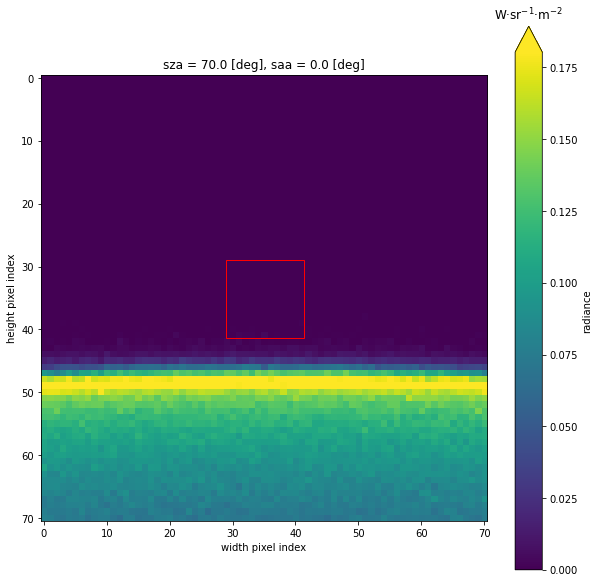

In [7]:
import matplotlib.patches as patches

# Create a Rectangle patch
rect = patches.Rectangle((measures['film_resolution'][0]//2-FOV_AtmoLITE_sim_pixel//2, measures['film_resolution'][0]//2-FOV_AtmoLITE_sim_pixel//2), FOV_AtmoLITE_sim_pixel, FOV_AtmoLITE_sim_pixel, linewidth=1, edgecolor='r', facecolor='none')

# Add the patch to the Axes
radiance = result.radiance.sum(axis=2).squeeze()
plot = radiance.plot.imshow(
    yincrease=False, robust=True, aspect=1, size=10
)
ax = plt.gca()
im = ax.images        
cb = im[-1].colorbar
ax.set_aspect('equal')
cb.ax.set_title('W·sr$^{-1}$·m$^{-2}$')
ax.add_patch(rect)

In [8]:
# https://www.gpixel.com/en/pro_details_1195.html
detector_edge_length = 22.5*(10**(-3)) #m
detector_pixel = 2024
image_edge_pixels = 900
image_edge_length = (image_edge_pixels/detector_pixel)*detector_edge_length
solidangle = 0.027 #steradian
etendue_NA_AtmoLITE = (image_edge_length**2)*solidangle
#power=etendue*radiance

In [9]:
#power=radiance*etendue
stray_light_power_distribution = radiance*etendue_NA_AtmoLITE

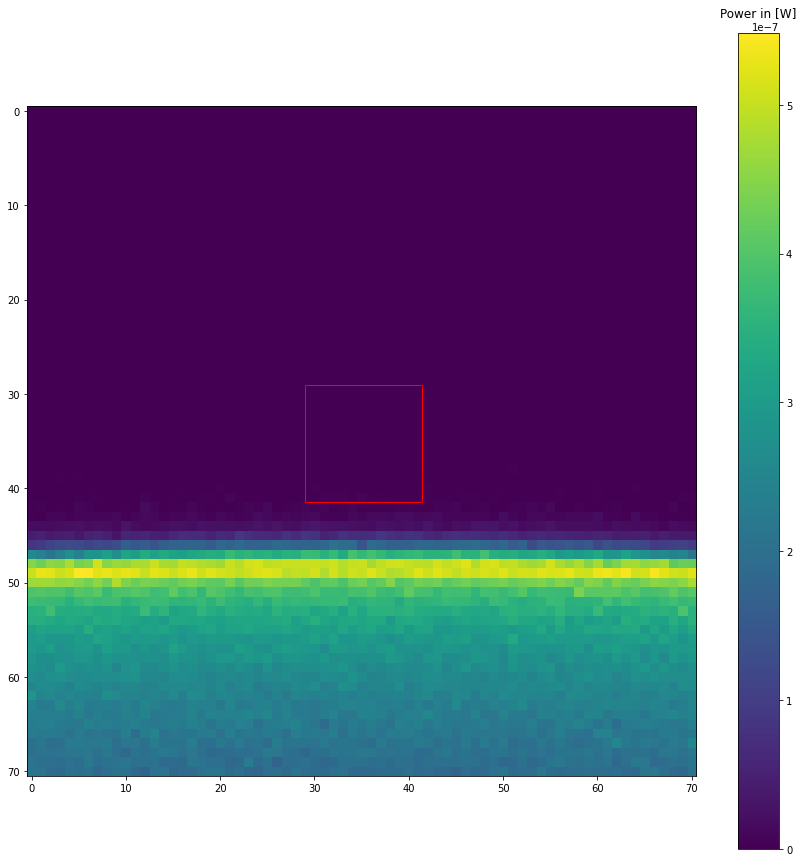

In [10]:
import matplotlib.pyplot as plt

plt.imshow(stray_light_power_distribution)
clb = plt.colorbar()
clb.ax.set_title('Power in [W]')
rect = patches.Rectangle((measures['film_resolution'][0]//2-FOV_AtmoLITE_sim_pixel//2, measures['film_resolution'][0]//2-FOV_AtmoLITE_sim_pixel//2), FOV_AtmoLITE_sim_pixel, FOV_AtmoLITE_sim_pixel, linewidth=1, edgecolor='r', facecolor='none')
plt.gca().add_patch(rect)
plt.show()